In [1]:
!cp drive/MyDrive/datasets/Diverse_hand_gesture_dataset.zip ./Diverse_hand_gesture_dataset.zip

In [2]:
!unzip -o -q Diverse_hand_gesture_dataset.zip

In [3]:
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from matplotlib import pyplot as plt
import os

In [4]:
class HandGestureGenerator(keras.utils.Sequence):
    def __init__(self, data_dir, random_state=42,test_size=0.2, shuffle=True, batch_size=32, mode='train',target_size=(224, 224), **kwargs):
        super(HandGestureGenerator, self).__init__(**kwargs)
        self.data_dir = data_dir
        self.images = []
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.len = 0
        self.classes = ["zero", "dislike", "five", "exactly", "two", "three", "left", "like"]
        self.mode = mode  # Can be 'train' or 'test'
        self.target_size = target_size
        self._load_data(test_size)
        self.indexes = np.arange(len(self.images))
        self.random_state=random_state
        np.random.seed(self.random_state)
        np.random.shuffle(self.images)

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.images))]
        images = [self.images[i] for i in indexes]

        X = []
        labels = []
        boxes = []

        for image_data in images:
            img_path = image_data["image"]
            img_org = keras.preprocessing.image.load_img(img_path, target_size=self.target_size)
            img_org = keras.preprocessing.image.img_to_array(img_org)
            img_height, img_width,_ = img_org.shape

            (label, (x_center, y_center, width, height)) = image_data["label"]

            x_min = float((x_center - (width / 2)))
            y_min = float((y_center - (height / 2)))
            x_max = float((x_center + (width / 2)))
            y_max = float((y_center + (height / 2)))

            X.append(img_org)
            labels.append(keras.utils.to_categorical(label, num_classes=len(self.classes)))
            boxes.append((x_min, y_min, x_max, y_max))

        X = np.array(X) / 255.0
        y = np.array(labels)
        boxes = np.array(boxes)
        if boxes.shape == (0,):
          print("Index:" ,index, index*self.batch_size, min((index+1)*self.batch_size,len(self.images)-1), self.indexes)

        return X, {
            "label": y,
            "box": boxes
        }

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.images, )

    def _load_data(self, test_size):
        all_images = []

        for filename in os.listdir(self.data_dir):
            if filename.endswith('.txt'):
                filepath = os.path.join(self.data_dir, filename)
                with open(filepath, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        line = line.strip()
                        parts = line.split()
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:])

                        img_filename = filename[:-4] + '.png'
                        img_filepath = os.path.join(self.data_dir, img_filename)
                        if os.path.exists(img_filepath):
                            all_images.append({"image": img_filepath, "label": (class_id, (x_center, y_center, width, height))})

        np.random.shuffle(all_images)
        split_idx = int(len(all_images) * (1 - test_size))

        if self.mode == 'train':
            self.images = all_images[:split_idx]
        else:
            self.images = all_images[split_idx+1:]



In [5]:
training_generator = HandGestureGenerator("train/", mode='train')
val_generator = HandGestureGenerator("train/", mode='val')

In [8]:
len(training_generator)

160

(0.285714, 0.276786) (0.598214, 0.84375)
(0.5625, 0.04464299999999999) (0.910714, 0.669643)
(0.3214285, 0.5) (0.6249995, 0.964286)
(0.441964, 0.08035749999999997) (0.848214, 0.7857145)


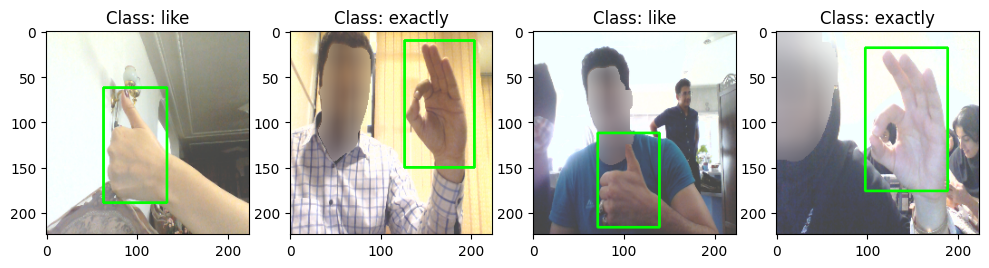

In [6]:
from PIL import Image
import cv2

image_array, y = training_generator[1]
boxes = y["box"]
labels = y["label"]
plt.figure(figsize=(100, 100))
img_width = image_array[0].shape[1]
img_height = image_array[0].shape[0]
for i in range(4):
  image = (image_array[i] * 255).astype('uint8')

  x_min = int((boxes[i][0]) * img_width)
  y_min = int((boxes[i][1]) * img_height)
  x_max = int((boxes[i][2]) * img_width)
  y_max = int((boxes[i][3]) * img_height)

  print((boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]))
  cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
  plt.subplot(1, len(image_array), i+1)
  plt.title(f'Class: {training_generator.classes[np.argmax(labels[i])]}')
  plt.imshow(image)

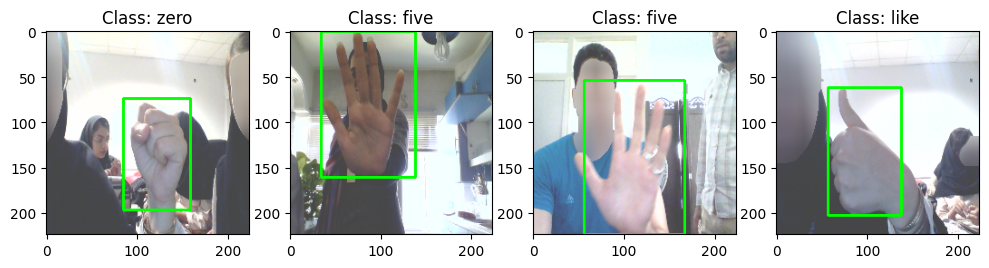

In [7]:
from PIL import Image
import cv2

image_array, y = val_generator[1]
boxes = y["box"]
labels = y["label"]
plt.figure(figsize=(100, 100))
img_width = image_array[0].shape[1]
img_height = image_array[0].shape[0]
for i in range(4):
  image = (image_array[i] * 255).astype('uint8')


  x_min = int((boxes[i][0]) * img_width)
  y_min = int((boxes[i][1]) * img_height)
  x_max = int((boxes[i][2]) * img_width)
  y_max = int((boxes[i][3]) * img_height)

  cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
  plt.subplot(1, len(image_array), i+1)
  plt.title(f'Class: {val_generator.classes[np.argmax(labels[i])]}')
  plt.imshow(image)

In [9]:
cnn = keras.applications.ResNet152V2(include_top=False, pooling="avg")
cnn.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="INPUT")
x = cnn(inputs)

## Box Dense Head
boxhead = layers.Dense(256, activation='relu')(x)
boxhead = layers.Dropout(0.2)(boxhead)
boxhead = layers.Dense(128, activation='relu')(boxhead)
boxhead = layers.Dropout(0.1)(boxhead)
boxhead = layers.Dense(64, activation='relu')(boxhead)
boxhead = layers.Dropout(0.1)(boxhead)
boxhead = layers.Dense(32, activation='relu')(boxhead)

## Label Dense Head
labelhead = layers.Dense(128, activation='relu')(x)
labelhead = layers.Dropout(0.2)(labelhead)
labelhead = layers.Dense(64, activation='relu')(labelhead)
labelhead = layers.Dropout(0.1)(labelhead)
labelhead = layers.Dense(32, activation='relu')(labelhead)

box_output = layers.Dense(4, activation='sigmoid', name="box")(boxhead)
class_output = layers.Dense(len(training_generator.classes), activation='softmax', name="label")(labelhead)

model = keras.Model(inputs=inputs, outputs=(class_output, box_output))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss={
    "label":'categorical_crossentropy',
    "box": 'mse'
}, metrics={
    "label": "accuracy",
    "box": None
})
model.summary()

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ INPUT (InputLayer)        │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet152v2 (Functional)  │ (None, 2048)           │     58,331,648 │ INPUT[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ resnet152v2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │        262,272 │ resnet152v2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          8,256 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 32)             │          2,080 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │          2,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (Dense)             │ (None, 8)              │            264 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ box (Dense)               │ (None, 4)              │            132 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 59,172,428 (225.72 MB)

 Trainable params: 840,780 (3.21 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [8]:
!pip install pydot

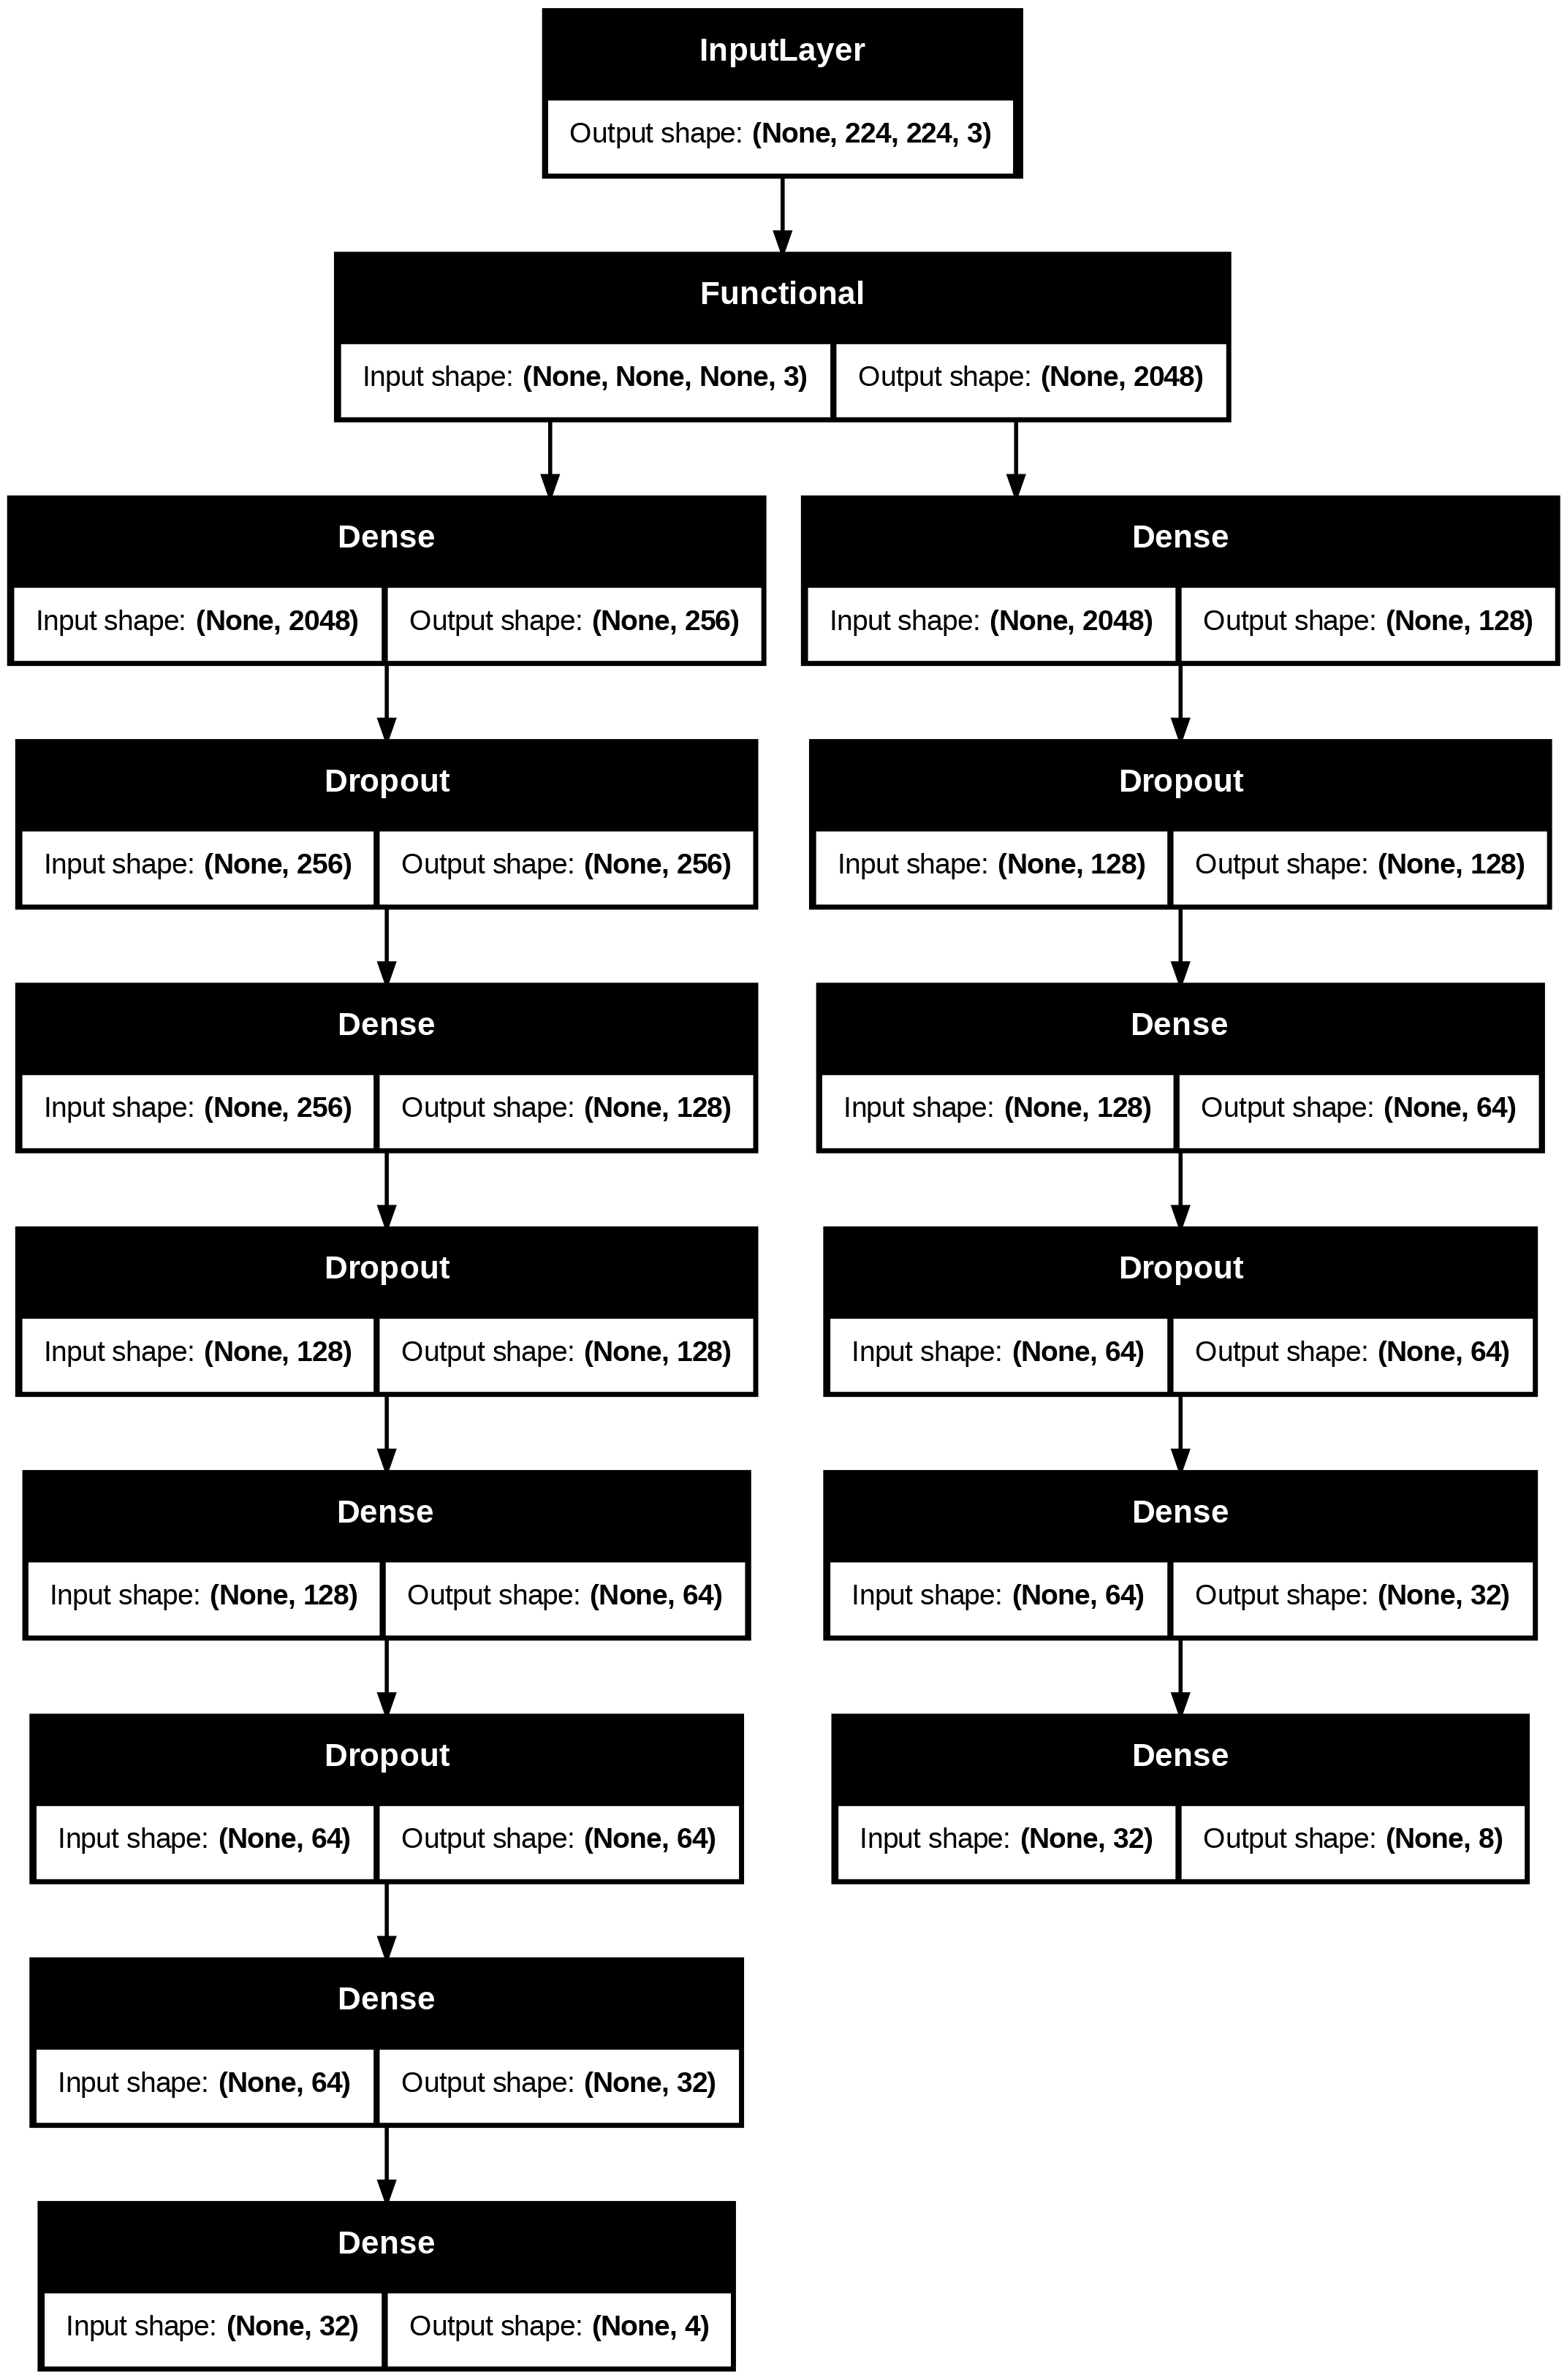

In [10]:
keras.utils.plot_model(model, show_shapes=True)

In [11]:
!cp drive/MyDrive/hand-model1.keras model1.keras

In [12]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [13]:
from keras.callbacks import TensorBoard

if os.path.exists("model1.keras"):
  model = keras.models.load_model("model1.keras")
else:
  tensor_board = TensorBoard(log_dir="logs", write_graph=True,write_steps_per_second=False, update_freq="batch")
  history = model.fit(
      training_generator,
      validation_data=val_generator,
      epochs=30,
      steps_per_epoch=len(training_generator),
      callbacks=[tensor_board],
      validation_steps=len(val_generator)
  )
  model.save("model1.keras")

In [14]:
results = model.evaluate(val_generator, steps=len(val_generator))
print("Validation label_loss:", results[0])
print("Validation label_accuracy:", f"{results[3]*100:.2f}%")

print("Validation box_loss:", f"{results[2]:.5f}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - box_loss: 0.0884 - label_accuracy: 0.8446 - label_loss: 0.7489 - loss: 0.8373
Validation label_loss: 0.7805606126785278
Validation label_accuracy: 84.29%
Validation box_loss: 0.09005


In [15]:
import matplotlib.pyplot as plt

def plotHistory(history, metrics):
  for metric in metrics:
    plt.figure(figsize=(10, 5))
    plt.plot(history[metric['key']], label=f'Training {metric["title"]}')
    plt.plot(history[f'val_{metric["key"]}'], label=f'Validation {metric["title"]}')
    plt.xlabel('Epoch')
    plt.ylabel(metric["title"])
    plt.title(f'Training and Validation {metric["title"]}')
    plt.legend()
    plt.show()

In [20]:
import pickle

if os.path.exists("training_history.pkl"):
  with open('training_history.pkl', 'rb') as f:
      history = pickle.load(f)

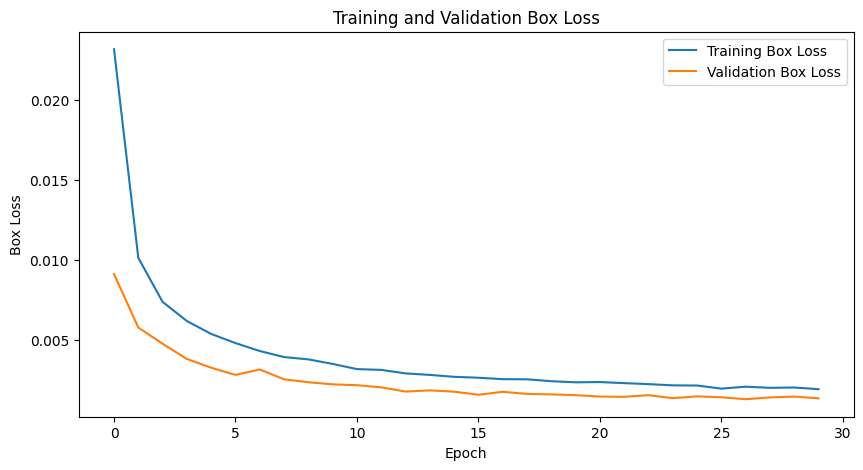

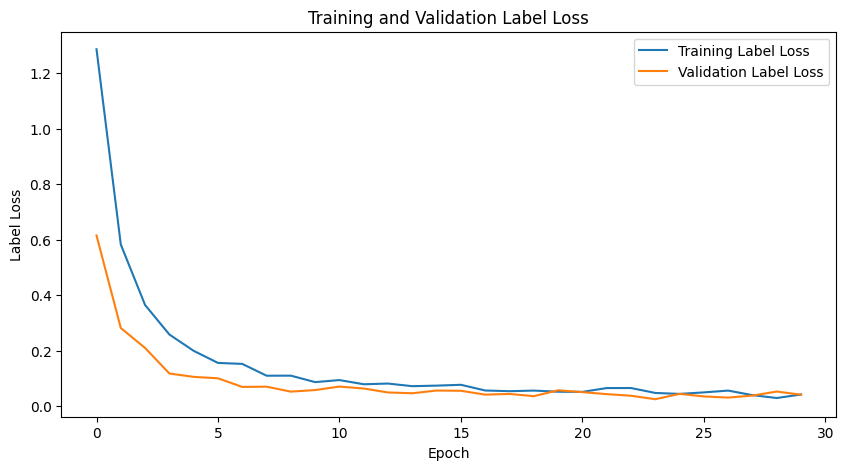

In [22]:
plotHistory(history.history, [{"key":"box_loss", "title":"Box Loss"}, {"key":"label_loss","title": "Label Loss"}])

In [16]:
!cp model1.keras drive/MyDrive/model1_hand_gesture_2.keras

In [ ]:
## also Fine tune resnet
for i, layer in enumerate(model.layers):
    if layer.name in ['resnet152v2']:
        model.layers[i].trainable = True
model.summary()

In [45]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard

reduce_lr = ReduceLROnPlateau(monitor='val_box_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_box_loss', patience=10, mode="min", restore_best_weights=True, start_from_epoch=10)
tensor_board = TensorBoard(log_dir="logs", write_graph=True,write_steps_per_second=False, update_freq="batch")
history2 = model.fit(
    training_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(training_generator),
    validation_steps=len(val_generator),
    callbacks=[reduce_lr, tensor_board, early_stopping]
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 48s 299ms/step - box_loss: 0.0018 - label_accuracy: 0.9908 - label_loss: 0.0226 - loss: 0.0244 - val_box_loss: 0.0013 - val_label_accuracy: 0.9928 - val_label_loss: 0.0350 - val_loss: 0.0363 - learning_rate: 0.0010
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 73s 243ms/step - box_loss: 0.0018 - label_accuracy: 0.9873 - label_loss: 0.0329 - loss: 0.0348 - val_box_loss: 0.0014 - val_label_accuracy: 0.9896 - val_label_loss: 0.0401 - val_loss: 0.0414 - learning_rate: 0.0010
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 233ms/step - box_loss: 0.0018 - label_accuracy: 0.9862 - label_loss: 0.0453 - loss: 0.0471 - val_box_loss: 0.0018 - val_label_accuracy: 0.9904 - val_label_loss: 0.0410 - val_loss: 0.0428 - learning_rate: 0.0010
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 45s 257ms/step - box_loss: 0.0018 - label_accuracy: 0.9866 - label_loss: 0.0428 - loss: 0.0446 - val_box_loss: 0.0013 - val_label_accuracy: 0.9864 - val_label_loss: 0.0579 - val_loss: 0.0592 - le

In [22]:
!cp drive/MyDrive/model_savepoint_2.keras model_savepoint_2.keras

In [23]:
model = keras.models.load_model("model_savepoint_2.keras")

In [18]:
model.save("model_savepoint_2.keras")

In [57]:
!cp model_savepoint_2.keras drive/MyDrive/

Seems like validation set is something easier than the training set for the model

In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ INPUT (InputLayer)        │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet152v2 (Functional)  │ (None, 2048)           │     58,331,648 │ INPUT[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ resnet152v2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │        262,272 │ resnet152v2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          8,256 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 32)             │          2,080 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │          2,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (Dense)             │ (None, 8)              │            264 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ box (Dense)               │ (None, 4)              │            132 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 177,229,798 (676.08 MB)

 Trainable params: 59,028,684 (225.18 MB)

 Non-trainable params: 143,744 (561.50 KB)

 Optimizer params: 118,057,370 (450.35 MB)

In [26]:
## Label head will overfit it I train it more
for i, layer in enumerate(model.layers):
    if layer.name in ['dense_6', 'dense_5', 'dense_4', "label"]:
        model.layers[i].trainable = False
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ INPUT (InputLayer)        │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet152v2 (Functional)  │ (None, 2048)           │     58,331,648 │ INPUT[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ resnet152v2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │        262,272 │ resnet152v2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          8,256 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 32)             │          2,080 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 32)             │          2,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (Dense)             │ (None, 8)              │            264 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ box (Dense)               │ (None, 4)              │            132 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 177,229,798 (676.08 MB)

 Trainable params: 58,755,812 (224.14 MB)

 Non-trainable params: 416,616 (1.59 MB)

 Optimizer params: 118,057,370 (450.35 MB)

In [29]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard

reduce_lr = ReduceLROnPlateau(monitor='val_box_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_box_loss', patience=4, mode="min", restore_best_weights=True, start_from_epoch=10)

## Change learning-rate
model.optimizer.learning_rate = 0.0001

## Fine-tune resenet for hand gestures
history3 = model.fit(
    training_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(training_generator),
    validation_steps=len(val_generator),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - box_loss: 0.0054 - label_accuracy: 0.9921 - label_loss: 0.0357 - loss: 0.0410 - val_box_loss: 0.0063 - val_label_accuracy: 0.9864 - val_label_loss: 0.0422 - val_loss: 0.0485 - learning_rate: 1.0000e-04
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - box_loss: 0.0054 - label_accuracy: 0.9962 - label_loss: 0.0129 - loss: 0.0183 - val_box_loss: 0.0033 - val_label_accuracy: 0.9992 - val_label_loss: 0.0014 - val_loss: 0.0046 - learning_rate: 1.0000e-04
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - box_loss: 0.0046 - label_accuracy: 0.9972 - label_loss: 0.0132 - loss: 0.0178 - val_box_loss: 0.0060 - val_label_accuracy: 0.9720 - val_label_loss: 0.1188 - val_loss: 0.1248 - learning_rate: 1.0000e-04
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - box_loss: 0.0062 - label_accuracy: 0.9866 - label_loss: 0.0619 - loss: 0.0681 - val_box_loss: 0.0067 - val_label_accuracy: 0.9920 - val_label_loss: 0.0254 - val_loss:

In [30]:
model.save("model_savepoint_3.keras")

In [31]:
!cp model_savepoint_3.keras drive/MyDrive/

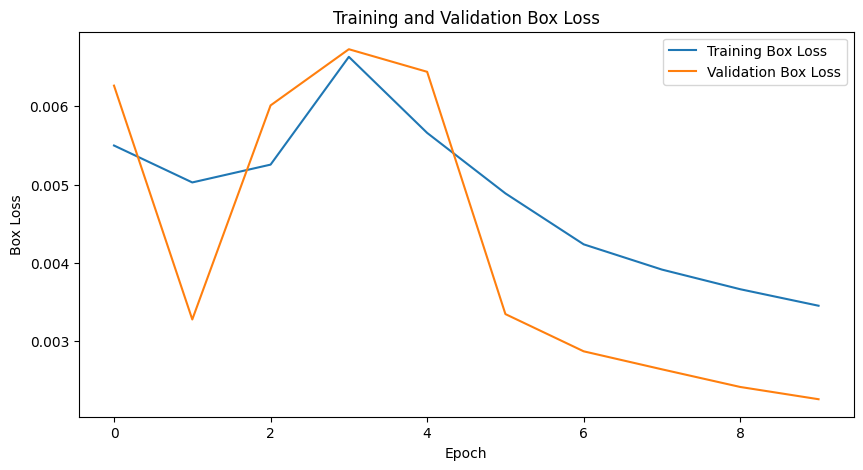

In [34]:
plotHistory(history3.history, [{"key":"box_loss","title": "Box Loss"}])

In [35]:
## Change learning-rate
model.optimizer.learning_rate = 0.0001

## Fine-tune resenet for hand gestures
history4 = model.fit(
    training_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(training_generator),
    validation_steps=len(val_generator),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - box_loss: 0.0032 - label_accuracy: 1.0000 - label_loss: 2.7663e-04 - loss: 0.0035 - val_box_loss: 0.0019 - val_label_accuracy: 0.9984 - val_label_loss: 0.0047 - val_loss: 0.0066 - learning_rate: 1.0000e-04
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - box_loss: 0.0034 - label_accuracy: 0.9981 - label_loss: 0.0112 - loss: 0.0146 - val_box_loss: 0.0091 - val_label_accuracy: 0.9856 - val_label_loss: 0.1511 - val_loss: 0.1602 - learning_rate: 1.0000e-04
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - box_loss: 0.0046 - label_accuracy: 0.9905 - label_loss: 0.0412 - loss: 0.0458 - val_box_loss: 0.0066 - val_label_accuracy: 0.9880 - val_label_loss: 0.0528 - val_loss: 0.0594 - learning_rate: 1.0000e-04
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - box_loss: 0.0062 - label_accuracy: 0.9841 - label_loss: 0.0685 - loss: 0.0746 - val_box_loss: 0.0039 - val_label_accuracy: 0.9968 - val_label_loss: 0.0061 - val_l

In [38]:
model.save("model_savepoint_4.keras")

In [39]:
!cp model_savepoint_4.keras drive/MyDrive/

In [70]:
class HandGestureGeneratorTest(HandGestureGenerator):
    def __init__(self, data_dir, random_state=42, shuffle=True, batch_size=32, mode='train',target_size=(224, 224), **kwargs):
        super(HandGestureGenerator, self).__init__(**kwargs)
        self.data_dir = data_dir
        self.images = []
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.len = 0
        self.classes = ["zero", "dislike", "five", "exactly", "two", "three", "left", "like"]
        self.mode = mode  # Can be 'train' or 'test'
        self.target_size = target_size
        self._load_data(1)
        self.indexes = np.arange(len(self.images))
        self.random_state = random_state
        np.random.seed(self.random_state)
        np.random.shuffle(self.images)

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.images))]
        images = [self.images[i] for i in indexes]

        X = []
        labels = []
        boxes = []

        for image_data in images:
            img_path = image_data["image"]
            img_org = keras.preprocessing.image.load_img(img_path, target_size=self.target_size)
            img_org = keras.preprocessing.image.img_to_array(img_org)
            img_height, img_width,_ = img_org.shape

            (label, (x_center, y_center, width, height)) = image_data["label"]

            X.append(img_org)
            labels.append(keras.utils.to_categorical(label, num_classes=len(self.classes)))
            boxes.append((x_center, y_center, width, height))

        X = np.array(X) / 255.0
        y = np.array(labels)
        boxes = np.array(boxes)

        return X, {
            "label": y,
            "box": boxes
        }

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.images, )

    def _load_data(self, test_size):
        all_images = []
        for className in self.classes:
          for filename in os.listdir(os.path.join(self.data_dir, className)):
              if filename.endswith('.png'):
                  filepath = os.path.join(self.data_dir, className, filename)
                  all_images.append({"image": filepath, "label": (self.classes.index(className), (0, 0, 0, 0))})

        np.random.shuffle(all_images)
        self.images = all_images

In [74]:
labels = training_generator.classes

test_dataset = HandGestureGeneratorTest("test/",random_state=24)

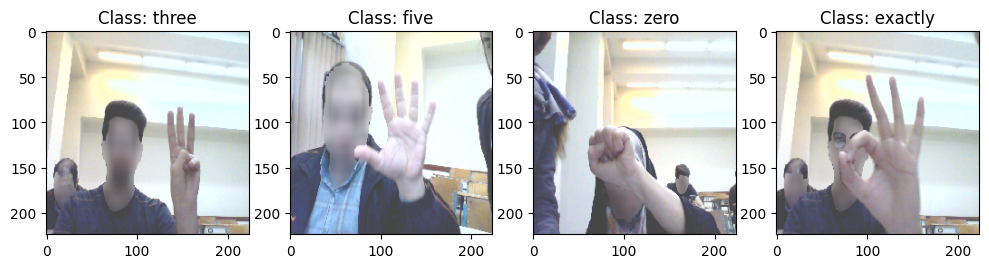

In [76]:
image_array, y = test_dataset[1]
boxes = y["box"]
labels = y["label"]
plt.figure(figsize=(100, 100))
img_width = image_array[0].shape[1]
img_height = image_array[0].shape[0]
for i in range(4):
  image = (image_array[i] * 255).astype('uint8')

  plt.subplot(1, len(image_array), i+1)
  plt.title(f'Class: {test_dataset.classes[np.argmax(labels[i])]}')
  plt.imshow(image)

In [78]:
results = model.evaluate(test_dataset, steps=len(test_dataset))
print("Validation label_loss:", results[0])
print("Validation label_accuracy:", f"{results[3]*100:.2f}%")

49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - box_loss: 0.3465 - label_accuracy: 0.9107 - label_loss: 0.3581 - loss: 0.7046
Validation label_loss: 0.7222143411636353
Validation label_accuracy: 90.94%


In [84]:
!cp model_savepoint_4.keras drive/MyDrive/hand_gesture_final_model.keras

Final Model:

https://drive.google.com/file/d/1-BcPK4b6aQAJut5gewzaY2H2FTigEunC/view?usp=sharing